In [2]:
pip install yfinance


In [3]:
!pip install pyspark


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=03e1ddfcdd3a2ded963a0c227ec2d6f33716ad04ca3e2b2087638ee0f3f3db92
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


[*********************100%%**********************]  1 of 1 completed


root
 |-- Date: timestamp (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Adj Close: double (nullable = true)
 |-- Volume: long (nullable = true)

+-------------------+-----------------+-----------------+-----------------+-----------------+-----------------+---------+
|               Date|             Open|             High|              Low|            Close|        Adj Close|   Volume|
+-------------------+-----------------+-----------------+-----------------+-----------------+-----------------+---------+
|2020-01-02 00:00:00|74.05999755859375| 75.1500015258789|73.79750061035156| 75.0875015258789|73.05941772460938|135480400|
|2020-01-03 00:00:00| 74.2874984741211| 75.1449966430664|           74.125|74.35749816894531| 72.3491439819336|146322800|
|2020-01-06 00:00:00|73.44750213623047|74.98999786376953|          73.1875|74.94999694824219|72.92562103271484|118387200|
|2

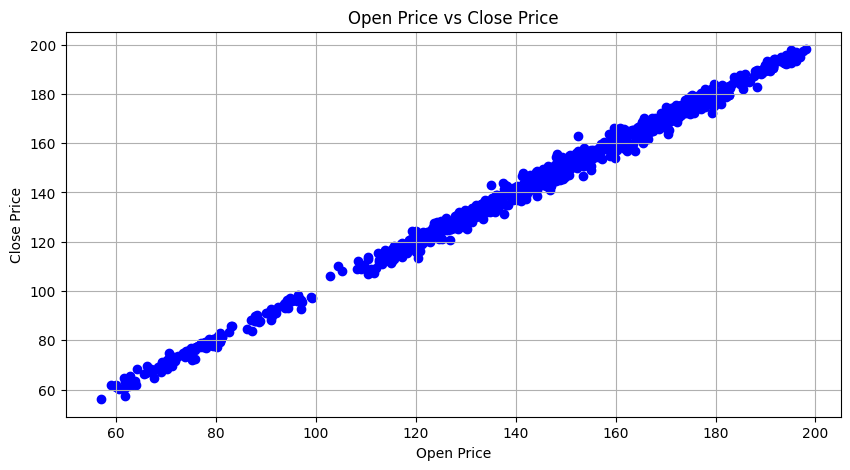

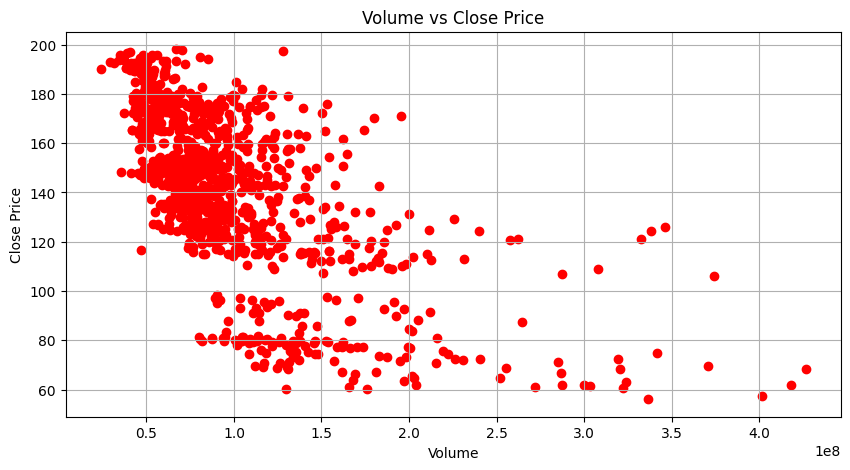

Root Mean Squared Error (RMSE) on test data = 2.03565
Coefficients: [0.9932559729144667,-3.9690543188646726e-09]
Intercept: 1.4324835911354539


In [7]:
import yfinance as yf
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt

# Initialize Spark session
spark = SparkSession.builder \
    .appName("Stock Market Prediction") \
    .getOrCreate()

# Fetch historical stock price data for a specific ticker (e.g., AAPL for Apple Inc.)
stock_data = yf.download('AAPL', start='2020-01-01', end='2024-01-01')

# Convert the pandas DataFrame to a Spark DataFrame
data = spark.createDataFrame(stock_data.reset_index())

# Display schema and first few rows
data.printSchema()
data.show(5)

# Display summary statistics
print("Summary Statistics:")
data.describe().show()

# Feature Engineering
# We'll use the 'Open' and 'Volume' columns as features
assembler = VectorAssembler(inputCols=["Open", "Volume"], outputCol="features")
data = assembler.transform(data)

# Convert Spark DataFrame to Pandas DataFrame for plotting
pandas_df = data.select("Open", "Volume", "Close").toPandas()

# Scatter plot for 'Open' vs 'Close'
plt.figure(figsize=(10, 5))
plt.scatter(pandas_df["Open"], pandas_df["Close"], color='blue')
plt.title("Open Price vs Close Price")
plt.xlabel("Open Price")
plt.ylabel("Close Price")
plt.grid(True)
plt.show()

# Scatter plot for 'Volume' vs 'Close'
plt.figure(figsize=(10, 5))
plt.scatter(pandas_df["Volume"], pandas_df["Close"], color='red')
plt.title("Volume vs Close Price")
plt.xlabel("Volume")
plt.ylabel("Close Price")
plt.grid(True)
plt.show()

# Split data into training and testing sets
(train_data, test_data) = data.randomSplit([0.8, 0.2], seed=42)

# Train a Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol="Close")
lr_model = lr.fit(train_data)

# Make predictions on the test data
predictions = lr_model.transform(test_data)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="Close", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

# Optional: You can print out the coefficients and intercept of the model
print("Coefficients: %s" % str(lr_model.coefficients))
print("Intercept: %s" % str(lr_model.intercept))

# Stop Spark session
spark.stop()
